# QDINE - Quantum Detection of time-serIes aNomaly for uniquE attendance.

## Table of Contents
- [Is this Santa Fe or Cagliari?](#intro)
- [Our Quest With Data](#data-quest)
  - [On the Dataset Generation](#data-gen)
  - [Synthetic Data Generation](#synth-data-gen)
  - [Dataset Settings](#data-settings)
- [Classical Models](#classic)
  - [A Standard One](#classic-standard)
  - [A Custom One](#classic-custom)
- [Quantum Time](#quantum)
 
<!-- @import "[TOC]" {cmd="toc" depthFrom=1 depthTo=6 orderedList=false} -->


## Is this Santa Fe or Cagliari? A tale of Time Series and Anomaly Detection  <a class="intro"></a>

The _Santa Fe Bar Problem_ (SFBP) was introduced by Brian Arthur, an economist at the Santa Fe Institute.[^1]

The problem statement is as follows: 
<p align="center">
    _Each week, 100 people decide independently whether or not to visit a popular bar that offers entertainment on a specific night. There’s limited space, and the evening is most enjoyable when the crowd stays under a certain limit—specifically, when fewer than 60 people show up. Each person decides based on whether they expect fewer than 60 others to be there; if they think fewer than 60 will attend, they’ll go. If they expect more than 60, they stay home.
    The only information available to each individual is the attendance numbers from previous weeks._
</p>

The question is which strategy should be adopted to either join or not the Santa Fe bar. 

Gathering all the data from the attendancies to the bar, we obtain a so-called _time-series_.
Let $T \subset R^{+}$ be a set of time instants. In the bar case, the different days. 
The time series $X = \{x_t : t \in T\}$ is a set of variables $x_t$ where each one holds the attendance value for time $t$.

Assume we are provided with some time-series $X$. The problems we are interested in solving are usually (per the literature) two:
1. Predicting the next value of the sequence. Assuming to look only at a portion of $X$, namely $X' = \{x_t : t \in T'\}$ with $T' < T$,
we want to predict $x_{t' + 1}$ where $t' = max(T')$ and $t' + 1$ is the successor of $t'$ in $T$. 
1. Identifying whether the whole sequence is an anomaly or not. More specifically, supposing to slice the sequence $X$ in a set of pairly disjoint continguous sub-sequences---_contiguous_ partitions---check if there one or more parts that are not _coherent_ with the others. 
The notion of _coherent_ is what we are interested in finding in this problem. For example, measuring the temperature of an oven, an _always high_ temperature for one hour is coherent, while it is not if we measure the temperature of a fridge. 

During this Hackathon, we decided to solve the second problem, usually introduced as _Anomaly Detection_ for the unique attendance dataset. 
The solution we adopted builds upon the notion of Quantum Kernel. 
In particular, some of the theoretical foundations are taken from the paper entitled Parallel hybrid quantum-classical machine learning for kernelized time-series classification[^2].

The reason why we highlighted that we used such reference only as a _partial theoretical background_ is twofold: 
1. Their notebook did not work properly, while our does :)
2. They used their model (Support Vector Machine) for classification, why we use ours (OneClass Support Vector Machine) for Anomaly Detection. 

In this notebook we will walk you through the solution we implemented using the notion introduced above

[^1]: W.B. Arthur (1994). _Inductive reasoning and bounded rationality_. Complexity in Economic Theory. URL: [https://www.jstor.org/stable/2117868](Read here) 

[^2]: Jack S. Baker et al (2024). _Parallel hybrid quantum-classical machine learning for kernelized time-series classification_. arXiv. URL: [https://arxiv.org/abs/2305.05881](Read here)

## Our quest with Data <a class="anchor" id="data-quest"></a>

In this part of the document we describe the road we paved to obtain all the required data for the model training and evaluation.

### On the Dataset Generation <a class="anchor" id="data-gen"></a>

Data about unique attendance were provided in 5 different files. 
Four of these described measurements about two weeks, while the last one about one single week. 
Each of these 5 files (no matter the time frame it covers) contained entries with the following form: 
<p align="center">
    T, V, Z
</p>
where:
* T indicates the time of the measurement. Such _datetime_ value included both date and time in which the data was gathered.
* V is simply the value measured in time T
* Z is the Zone to which the value V refers to. There are 13 different zones and a _cumulative_ one that describes the sum of the other 13.  

The measurement and performed as follows: every 15 minutes, a new value V per each of the 13 zones is measured. 
Therefore, every 15 minutes we have 14 measures. Every hour we have 60 measures (in total) and four per zone. For other timeslots, math is straightforward.

Using all of the above considerations, we manipulated input data so that measures are gathered by zone. 
Roughly speaking, we obtain a set $S$ composed of 14 big samples where $S_i$ is the set of all the measurements done in zone $S$ combining all the five files, sorted by datetime asc. 

Subsequently, let $z$ be one of the 14 possibile zones. We took $S_z$ and split it in chunks comprising only seven days (672 entries per chunk, in particular 96 $\times$ 7, where 96 is the number of measurements per zone in one day).
This operation splits $S_z$ in 9+1 samples $S_{z,1}, S_{z,2}, ..., S_{z_10}$. We mentioned 9 + 1 since the last one is shorter that the other. 
The set of all the nine samples $S_{z, i}$ for all the possible $z \in \{1, ..., 14\} and all the possible $i \in \{1, ..., 9\}$ is our input data.

Such information are provided in the file _data_week.csv_ which we read using the following block.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dtaidistance import dtw
import itertools
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import random

df = pd.read_csv("data_weeks.csv", header=None)



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\39331\anaconda3\envs\qiskit\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\39331\anaconda3\envs\qiskit\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\39331\anaconda3\envs\qiskit\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:

We now proceed with the data manipulation by applying a normalization step. 
What we obtain is a set of data where all values range between 0 and 1. 
Moreover, from each sample we remove the first entry which is the name of the zone. 

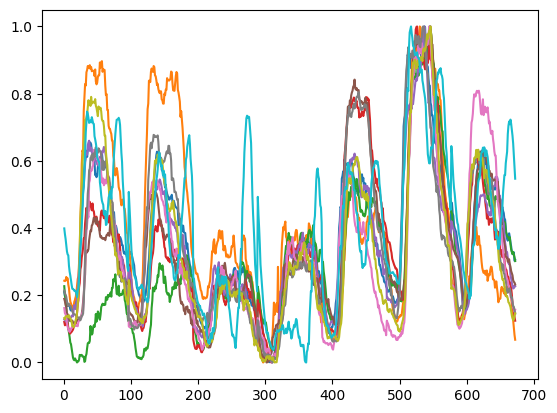

In [3]:
# NORMALIZATION BY ROW
rows = df.values
for row in rows:
    line_values = row[1:]
    norm_row = (line_values - line_values.min()) / (line_values.max() - line_values.min())
    row[1:] = norm_row

df_norm = pd.DataFrame(rows)
#print(df_norm.head)

first_column = df_norm.columns[0]
df_norm = df_norm.drop(columns=first_column)

# plot 10 samples
for i in range(10):
    plt.plot(df_norm.iloc[i])
plt.show()

### Synthetic Data Generation <a class="anchor" id="synth-data-gen"></a>

Now that the _actual_ data are loaded, we proceed with the generation of a set of _synthetic_ data. 
This set of data is fundamental to understand if the model can actually recognize time-series anomaly. 


In [4]:
import numpy as np
import matplotlib.pyplot as plt


The first data that we need in our set of synthetic tools is a completely random noise dataset.

In [5]:
def generate_random_noise(leng=672, seed=None):
    if seed is not None:
        np.random.seed(seed)

    ts = np.random.normal(0, 0.1, leng)
    ts = (ts - ts.min())/(ts.max()-ts.min())

    return ts

We then generate the so-called _Perlin_ noise.

In [6]:
def fade(t):
    # Fade function as defined by Ken Perlin
    return t * t * t * (t * (t * 6 - 15) + 10)

def lerp(a, b, t):
    # Linear interpolation between a and b
    return a + t * (b - a)

def gradient(h, x):
    # Compute the gradient for 1D Perlin noise
    g = h & 15
    grad = 1 + (g & 7)  # Gradient is one of 1, 2, ..., 8
    if g & 8:
        grad = -grad
    return grad * x

def perlin(x, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    # Calculate unit grid cell containing the point
    X = int(np.floor(x)) & 255

    # Relative x coordinate in the grid cell
    x -= np.floor(x)

    # Compute fade curves for x
    u = fade(x)

    # Hash coordinates of the corners
    p = np.arange(256, dtype=int)
    np.random.shuffle(p)
    p = np.concatenate([p, p])

    # Gradient vectors for corners
    g1 = gradient(p[X], x)
    g2 = gradient(p[X+1], x-1)

    # Interpolate between gradients
    return lerp(g1, g2, u)

def generate_perlin_noise(leng=672, scale=100, seed=None):
    if seed is not None:
        np.random.seed(seed)

    noise = np.zeros(leng)
    for i in range(leng):
        x = i / scale
        noise[i] = perlin(x, seed=seed)

    # Normalize the noise to range [0, 1]
    noise = (noise - noise.min()) / (noise.max() - noise.min())
    
    return noise

Finally, a random time series. We decided to base the generation on the sine function with the same period of the data analyzed (i.e. 24 hours). We handcrafted some noise functions to obtain something that is "similar" to the real data.

In [7]:


def generate_random_time_series(leng=672, seed=None):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    else:
        np.random.seed()
        random.seed()
    
    indices = np.arange(leng)
    
    # Generate reduced noise and interpolate
    reduced_noise = np.random.normal(0, 0.5, int(leng/30))
    x_old = np.linspace(0, leng, len(reduced_noise))
    x_new = np.linspace(0, leng, leng)
    extended_noise = np.interp(x_new, x_old, reduced_noise)
    extended_noise = np.concatenate((np.zeros(leng - len(extended_noise)), extended_noise))
    
    # Create random noise
    noise = np.random.normal(0, 0.02, leng)
    
    def scaling_amplitude(x):
        centrality_factor = abs(x - np.mean(x))
        y = 1.2 - (random.random() - 0.5) * centrality_factor * np.cos(random.random() * np.pi * 0.1 * x + random.random() * 0.2) + random.random()
        return y
    
    def scaled_sine_wave(x):
        offset = random.random() * 10
        return 0.5 * np.sin(2 * np.pi * x / 96 + offset) + 0.5
    
    def scaled_line(x):
        return (x - random.random())**2 + x * 0.1
    
    x_scaled = indices / leng + noise
    ts = scaled_sine_wave(indices) * scaling_amplitude(x_scaled) * (1 + extended_noise) + (random.random()-0.4)*10 * scaled_line(x_scaled)
    
    # Normalize to 0-1
    ts_min = np.min(ts)
    ts_max = np.max(ts)
    ts_normalized = (ts - ts_min) / (ts_max - ts_min)
    
    return ts_normalized

Once all the synthetic datasets have been generated, we would like to look at their shapes to see what kind of monster we are facing. 

C:\Users\39331\AppData\Local\Temp\ipykernel_25120\1108749740.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
C:\Users\39331\AppData\Local\Temp\ipykernel_25120\1108749740.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()
C:\Users\39331\AppData\Local\Temp\ipykernel_25120\1108749740.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend()


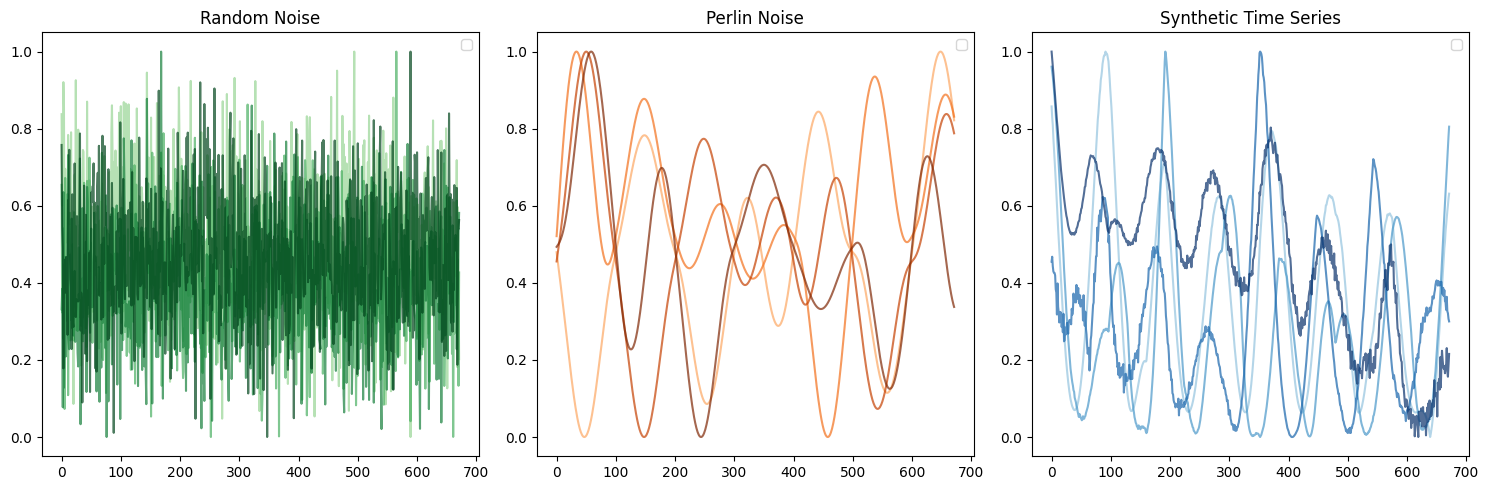

In [8]:

import matplotlib.pyplot as plt
import numpy as np

N = 4

# Define colors for each type of time series with different shades
greens = plt.cm.Greens(np.linspace(0.4, 1, N))  # Shades of green for random noise
blues = plt.cm.Blues(np.linspace(0.4, 1, N))    # Shades of blue for synthetic time series
oranges = plt.cm.Oranges(np.linspace(0.4, 1, N))  # Shades of orange for Perlin noise

# Initialize lists to store different types of time series data
anomalous_data_random = []
anomalous_data_noise = []
anomalous_data_perlin = []

# Generate time series of each type
for i in range(N):
    anomalous_data_random.append(generate_random_time_series(seed=i))
    anomalous_data_noise.append(generate_random_noise(seed=i))
    anomalous_data_perlin.append(generate_perlin_noise(seed=i))

# Create subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot random noise with shades of green
for i, series in enumerate(anomalous_data_noise):
    axes[0].plot(series, color=greens[i], alpha=0.7)
axes[0].set_title('Random Noise')
axes[0].legend()

# Plot Perlin noise with shades of orange
for i, series in enumerate(anomalous_data_perlin):
    axes[1].plot(series, color=oranges[i], alpha=0.7)
axes[1].set_title('Perlin Noise')
axes[1].legend()

# Plot synthetic time series with shades of blue
for i, series in enumerate(anomalous_data_random):
    axes[2].plot(series, color=blues[i], alpha=0.7)
axes[2].set_title('Synthetic Time Series')
axes[2].legend()



# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plots
plt.show()



### Dataset settings <a class="anchor" id="data-settings"></a>

We now deal with aggregating all the data (for train, test and anomaly) before feeding classical models with that.

In [9]:
CONFIGS = {
    "TRAIN_SAMPLES" : 50,
    "NORMAL_SAMPLES" : 50,
    "ANOMALY_SAMPLES" : 50,
}


np.random.seed(0)
all_indices = np.arange(df_norm.shape[0])
train_indices = np.random.choice(all_indices, CONFIGS["TRAIN_SAMPLES"], replace=False)
remaining_indices = np.setdiff1d(all_indices, train_indices)
test_indices = np.random.choice(remaining_indices, CONFIGS["NORMAL_SAMPLES"], replace=False)
# save them as matrixes
train = df_norm.iloc[train_indices].values
test = df_norm.iloc[test_indices].values
# save the matrixes in csv files
np.savetxt("train_norm.csv", train, delimiter=",", fmt="%s")
np.savetxt("test_norm.csv", test, delimiter=",", fmt="%s")
# print the shapes
print('Train shape:', train.shape)
print('Test shape:', test.shape)

anomaly_series = []
for i in range(CONFIGS["ANOMALY_SAMPLES"]):
    ts = generate_random_noise(seed=i)
    anomaly_series.append(ts)
random_noise_series = np.array(anomaly_series)

anomaly_series = []
for i in range(CONFIGS["ANOMALY_SAMPLES"]):
    ts = generate_perlin_noise(seed=i)
    anomaly_series.append(ts)
perlin_noise_series = np.array(anomaly_series)


anomaly_series = []
for i in range(CONFIGS["ANOMALY_SAMPLES"]):
    ts = generate_random_time_series(seed=i)
    anomaly_series.append(ts)
synthetic_series = np.array(anomaly_series)


# ====================================================================================================

Train shape: (50, 672)
Test shape: (50, 672)


## Classical Models <a class="anchor" id="classic"></a>

We are now ready to define standard (classical) prediction models to solve the OneClassSVM problem.

### A Standard One <a class="anchor" id="classic-standard"></a>
The first model is a completely _standard_ one, which autonomously computes the kernel. In particular it computes a non-time dependent kernel.

In [12]:
def standard_model(train, test, anomalies, kernel_code):
    one_class_svm = OneClassSVM(kernel=kernel_code, nu=0.1)
    one_class_svm.fit(train)
    test_predictions = one_class_svm.predict(test)


    # compute accuracy of normal samples
    test_labels = np.ones(test.shape[0])
    test_accuracy = accuracy_score(test_labels, test_predictions)

    # compute accuracy of anomaly samples
    print(f"Accuracy on normal samples: {test_accuracy}")
    
    for anomaly in anomalies:
        anomaly_predictions = one_class_svm.predict(anomaly)
        anomaly_labels = -1 * np.ones(anomaly.shape[0])
        anomaly_accuracy = accuracy_score(anomaly_labels, anomaly_predictions)
        print(f"Accuracy on anomaly samples: {anomaly_accuracy}")




In [10]:
def calculate_temporal_similarity(series1, series2):
    distance, paths = dtw.warping_paths(series1, series2, use_c=False)
    best_path = dtw.best_path(paths)
    similarity_score = distance / len(best_path)
    return similarity_score

In [11]:
TYPES = {"TRAIN_KERNEL", "TEST_KERNEL", "ANOMALY_KERNEL"}

def generate_custom_kernel(DATASET1, DATASET2, TYPE, function, to_swap = True):
    if TYPE == "TRAIN_KERNEL":
        similarity_matrix = np.zeros((DATASET1.shape[0], DATASET1.shape[0]))
        train_combinations = list(itertools.combinations(range(DATASET1.shape[0]), 2))
        for i, j in tqdm(train_combinations):
        # series 1 is the first row
            X1 = DATASET1[i]
            # series 2 is the second row
            X2 = DATASET2[j]
            # Ensure both series are the same length before applying DTW
            assert len(X1) == len(X2)

            similarity_score = function(X1, X2)
            similarity_matrix[i, j] = similarity_score
            similarity_matrix[j, i] = similarity_score  # Symmetric matrix

        if to_swap:
            similarity_matrix = 1 - (similarity_matrix / np.max(similarity_matrix))
        np.fill_diagonal(similarity_matrix, 1)

    elif TYPE == "TEST_KERNEL" or TYPE == "ANOMALY_KERNEL":
        similarity_matrix = np.zeros((DATASET1.shape[0], DATASET2.shape[0]))
        test_combinations = list(itertools.product(range(DATASET1.shape[0]), range(DATASET2.shape[0])))
        for i, j in tqdm(test_combinations):
            X1 = DATASET1[i]
            X2 = DATASET2[j]

            similarity_score = function(X1, X2)
            similarity_matrix[i, j] = similarity_score
    
        if to_swap:
                similarity_matrix = 1 - (similarity_matrix / np.max(similarity_matrix))
    return similarity_matrix

In [13]:
def custom_model(train_kernel, test_kernel, anomalies, info):
    one_class_svm = OneClassSVM(kernel='precomputed', nu=0.1)
    one_class_svm.fit(train_kernel)
    test_predictions = one_class_svm.predict(test_kernel)
    
    # compute accuracy of normal samples
    test_labels = np.ones(test_kernel.shape[0])
    test_accuracy = accuracy_score(test_labels, test_predictions)
    
    print(f"Accuracy on normal samples: {test_accuracy}")

    for anomaly in anomalies:
        anomaly_predictions = one_class_svm.predict(anomaly)
        anomaly_labels = -1 * np.ones(anomaly.shape[0])
        anomaly_accuracy = accuracy_score(anomaly_labels, anomaly_predictions)
        print(f"Accuracy on anomaly samples: {anomaly_accuracy}")





Now that the model has been declared, we can test using the synthetic data computed before (random, perlin and synthetic) against three different kernels: 
* linear
* rbf
* polynomial

In [35]:
anomalies = [random_noise_series, perlin_noise_series, synthetic_series]

standard_model(train, test, anomalies, 'linear')
standard_model(train, test, anomalies, 'rbf')
standard_model(train, test, anomalies, 'poly')


Accuracy on normal samples: 0.82
Accuracy on anomaly samples: 0.02
Accuracy on anomaly samples: 0.06
Accuracy on anomaly samples: 0.6
Accuracy on normal samples: 0.66
Accuracy on anomaly samples: 0.72
Accuracy on anomaly samples: 1.0
Accuracy on anomaly samples: 0.96
Accuracy on normal samples: 0.78
Accuracy on anomaly samples: 0.04
Accuracy on anomaly samples: 0.1
Accuracy on anomaly samples: 0.66


### A Custom One <a class="anchor" id="classic-custom"></a>
On the other hand, the _custom_ model, asks for the kernel to be provided as an input. To provide a time-dependent kernel, we compute the temporal similarity by the Dynamic Time Warping kernel.
[Be careful: this may require a lot of time!]

In [34]:
K_train = generate_custom_kernel(train, train, "TRAIN_KERNEL", calculate_temporal_similarity)
K_test = generate_custom_kernel(test, train, "TEST_KERNEL", calculate_temporal_similarity)

K_noise = generate_custom_kernel(random_noise_series, train, "ANOMALY_KERNEL", calculate_temporal_similarity)
K_perlin = generate_custom_kernel(perlin_noise_series, train, "ANOMALY_KERNEL", calculate_temporal_similarity)
K_synthetic = generate_custom_kernel(synthetic_series, train, "ANOMALY_KERNEL", calculate_temporal_similarity)



100%|██████████| 2500/2500 [31:50<00:00,  1.31it/s]


It is now kernel time (literally). This snippet of code is devoted to the computation of the time-dependent kernels that will be necessary to test the custom model. 

In [36]:
Ks = [K_noise, K_perlin, K_synthetic]
custom_model(K_train, K_test, Ks, "DTW")

Accuracy on normal samples: 0.94
Accuracy on anomaly samples: 1.0
Accuracy on anomaly samples: 0.04
Accuracy on anomaly samples: 0.72


Let's some some kernels!

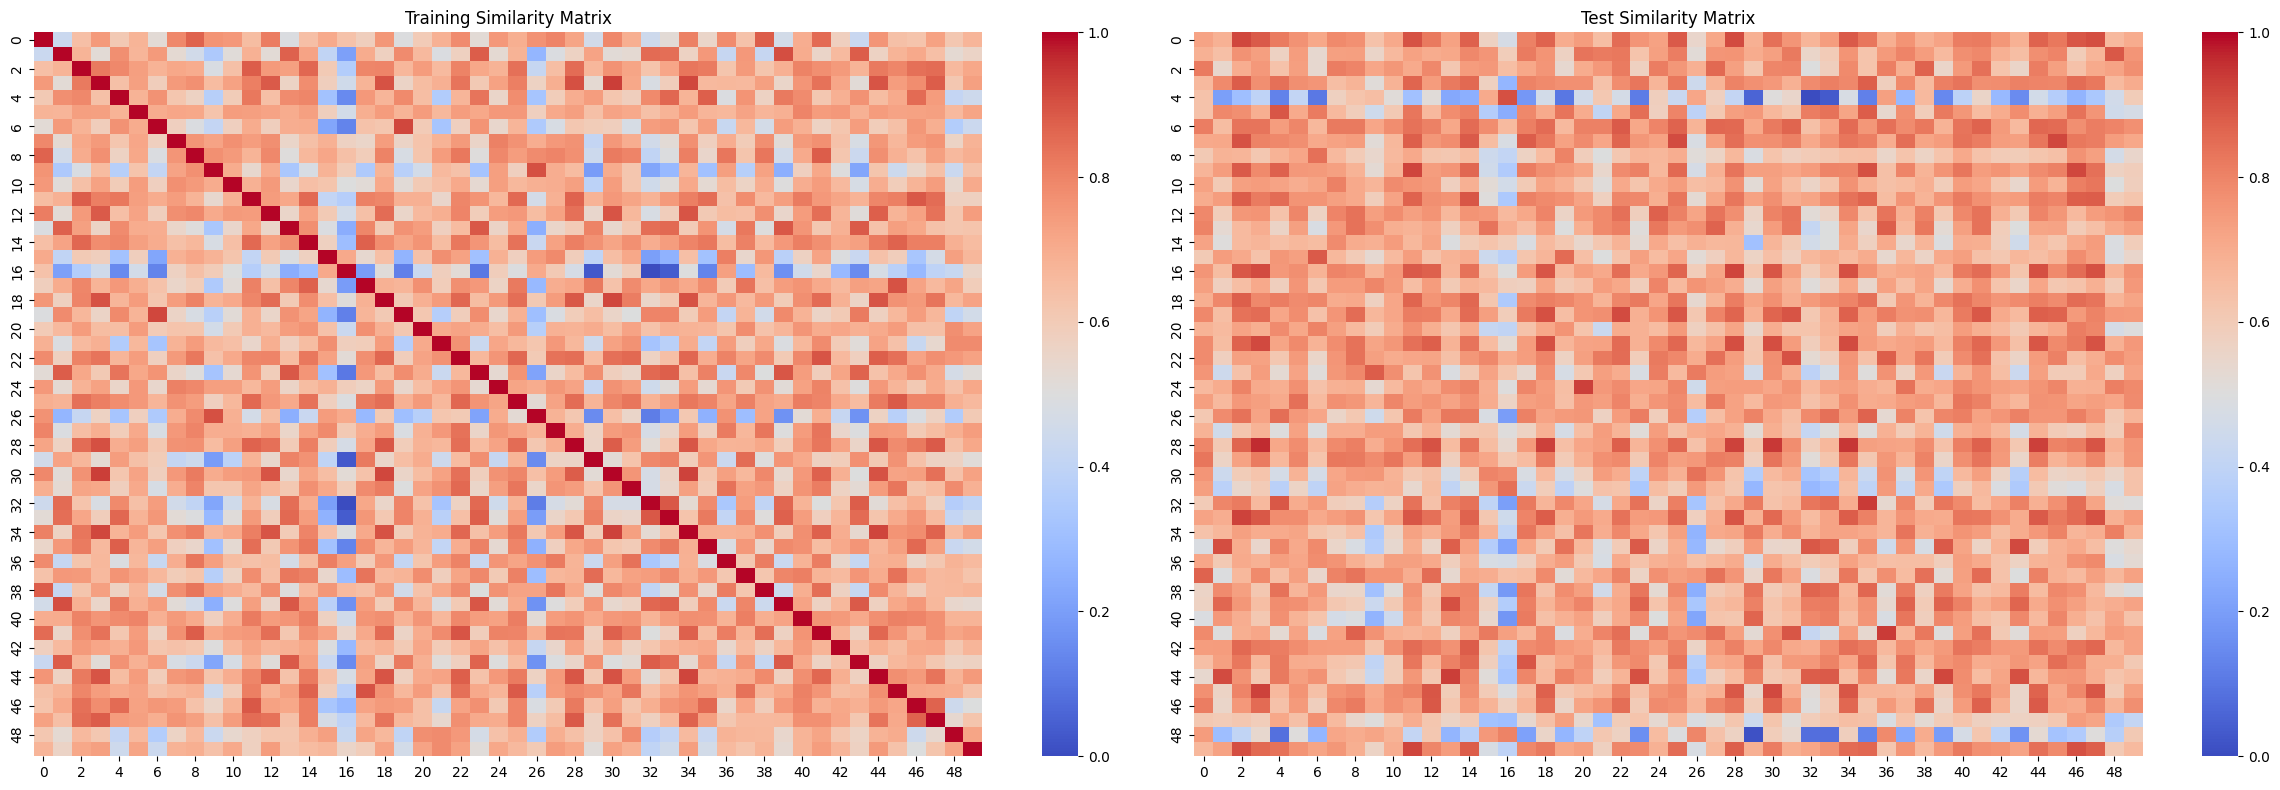

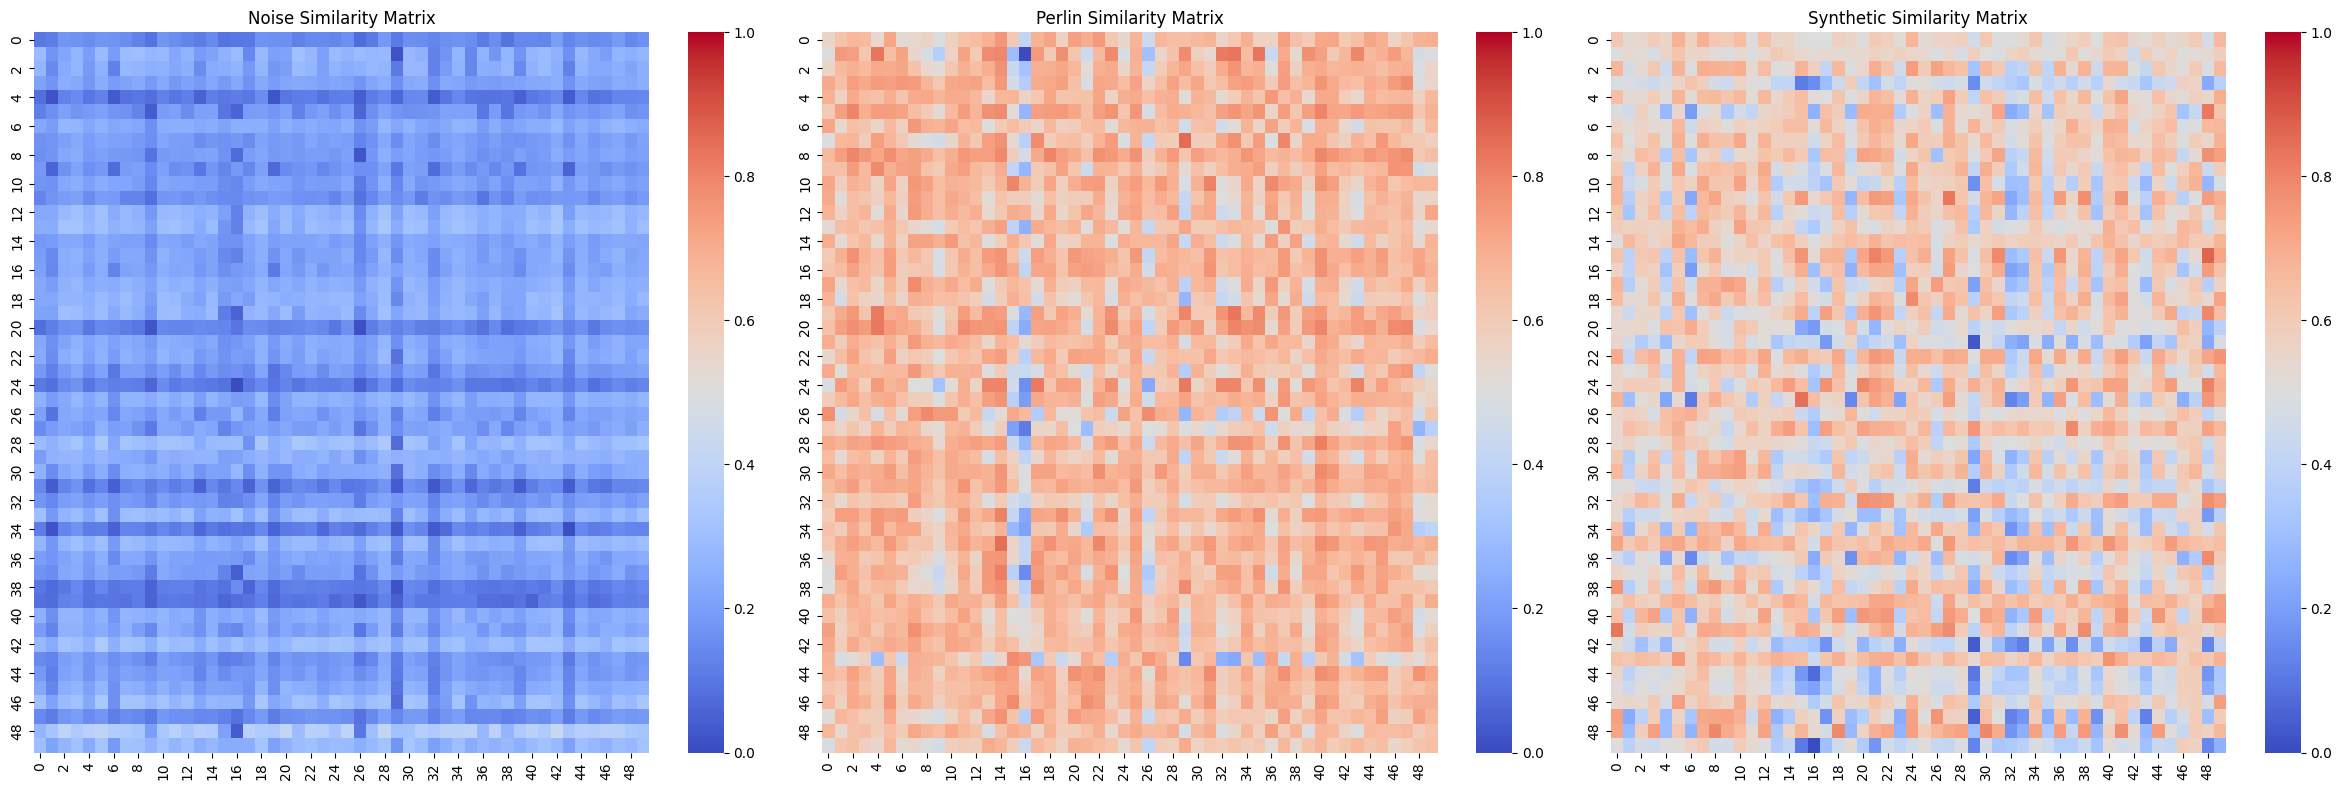

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

TO_PRINT = True
if TO_PRINT:
    fig, axes = plt.subplots(1, 2, figsize=(24, 8))  # Create a grid with 1 row and 3 columns

    # Training Similarity Matrix
    sns.heatmap(K_train, annot=False, cmap='coolwarm', vmin=0, vmax=1, ax=axes[0])
    axes[0].set_title('Training Similarity Matrix')

    # Test Similarity Matrix
    sns.heatmap(K_test, annot=False, cmap='coolwarm', vmin=0, vmax=1, ax=axes[1])
    axes[1].set_title('Test Similarity Matrix')

    plt.tight_layout()  # Adjusts spacing to prevent overlap
    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # Create a grid with 1 row and 3 columns

    # Noise Similarity Matrix
    sns.heatmap(K_noise, annot=False, cmap='coolwarm', vmin=0, vmax=1, ax=axes[0])
    axes[0].set_title('Noise Similarity Matrix')

    # Perlin Similarity Matrix
    sns.heatmap(K_perlin, annot=False, cmap='coolwarm', vmin=0, vmax=1, ax=axes[1])

    axes[1].set_title('Perlin Similarity Matrix')

    # Synthetic Similarity Matrix
    sns.heatmap(K_synthetic, annot=False, cmap='coolwarm', vmin=0, vmax=1, ax=axes[2])
    axes[2].set_title('Synthetic Similarity Matrix')

    plt.tight_layout()  # Adjusts spacing to prevent overlap
    plt.show()


## It is finally QUANTUM TIME <a class="anchor" id="quantum"></a>

Now that a classical comparison baseline has been obtained, we can move to the quantum stuff. 
The main objective of the quantum component is to compute a time-dependent kernel.  
Quantum kernels mainly build upon the following circuit: 
<p align="center">
  <img src="Kernel-Circ.png" width="350" title="hover text">
</p>

Formally speaking, a Quantum Kernel computes the similarity between two inputs in a farly _simple_ way. 
The circuit, in fact, is made of two major blocks. 
Firstly, one of the two samples is encoded in a quntum state using angle, amplitude and a custom embedding ($\phi(x_i)$ in the image).
Subsequently, the state resulting from this encoding together with $x_j$ are provided to a second copy of the same embedding function. 

By measuring the resulting state, we obtain a measure of similarity.
Henceforth, our duty is to write a (i) good embedding function that is (ii) time-dependent. 

What we obtained is defined in the following snippet of code. 
Roughly speaking, the theoretical ingredients (magic, thanks Merlin [or Euler?]) we used are:
* Euler angles of the form $z, y, z$ 
* Irrational fractions of $\pi$ adopting $\sqrt{2}$

In [14]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.primitives.sampler import Sampler

from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
import numpy as np
from scipy.linalg import expm

H_X = np.array([[0, 1],
                [1, 0]]) 

# use H as pauli Y gate
H_Y = np.array([[0, -1j],
                [1j, 0]])

H_Z = np.array([[1, 0],
                [0, -1]])

H_I = np.eye(2)

H_weights = np.random.rand(4)

H = 0.3 * H_Z + 0.7 * H_Y

def evaluate_inner_product(x1, x2, leng, t, H):
# Create the two quantum states |ψ⟩ and |φ⟩
    psi = QuantumCircuit(1)
    phi = QuantumCircuit(1)
    U = expm(-1j * H * 2*np.pi*t/leng)

    psi.unitary(Operator(U), [0])
    psi.rz(x1*np.pi*np.sqrt(2), 0)
    psi.ry(x1*np.pi*np.sqrt(2), 0)
    psi.rz(x1*np.pi*np.sqrt(2), 0)
    psi.u(x1, 0, x1**2, 0)

    phi.unitary(Operator(U), [0])
    phi.rz(x2*np.pi*np.sqrt(2), 0)
    phi.ry(x2*np.pi*np.sqrt(2), 0)
    phi.rz(x2*np.pi*np.sqrt(2), 0)
    phi.u(x2, 0, x2**2, 0)


    psi_inv = psi.inverse()

    #compose the circuits
    phi.compose(psi_inv, inplace=True)
    #print(phi)
    # Combine the circuits to measure the inner product
    qc_measured = phi.measure_all(inplace=False)

    # 3. Execute using the Sampler primitive

    sampler = Sampler()
    job = sampler.run(qc_measured, shots=1000)
    result = job.result()
    #print(f" > Quasi probability distribution: {result.quasi_dists}")
    try:
        inner_product = result.quasi_dists[0][0]
    except:
        inner_product = 0
    return inner_product

Once the kernel has been implemented, it must be evaluated. 

In [15]:
import random

random.seed(0)
np.random.seed(0)

my_leng = 672
weights = np.random.rand(my_leng)
for i in range(len(weights)):
    if random.random() < 0.95:
        weights[i] = 0
#print(weights)
# normalize weights such that their sum is 1
weights = weights / np.sum(weights)    
#print(weights)

print(f"Non-zero weights: {np.count_nonzero(weights)}")

def evaluate_Qkernel_similarity(x1, x2, custom_inner_product):
    assert len(x1) == len(x2)
    leng = len(x1)
    kernel_value = 0
    for t in range(leng):
        if weights[t] != 0:
            kernel_value += weights[t] * custom_inner_product(x1[t], x2[t], leng, t, H)
    return kernel_value
    

def my_qkernel(x1, x2):
    return evaluate_Qkernel_similarity(x1, x2, evaluate_inner_product)

Non-zero weights: 32


Finally, we can generate the kernels (on all datasets) using the quantum kernels.

In [16]:
K_train = generate_custom_kernel(train, train, "TRAIN_KERNEL", my_qkernel, to_swap=False)
K_test = generate_custom_kernel(test, train, "TEST_KERNEL", my_qkernel, to_swap=False)

K_noise = generate_custom_kernel(random_noise_series, train, "ANOMALY_KERNEL", my_qkernel, to_swap=False)
K_perlin = generate_custom_kernel(perlin_noise_series, train, "ANOMALY_KERNEL", my_qkernel, to_swap=False)
K_synthetic = generate_custom_kernel(synthetic_series, train, "ANOMALY_KERNEL", my_qkernel, to_swap=False)

Ks = [K_noise, K_perlin, K_synthetic]
custom_model(K_train, K_test, Ks, "Quantum Kernel")


100%|██████████| 2500/2500 [05:10<00:00,  8.04it/s]

Accuracy on normal samples: 0.8
Accuracy on anomaly samples: 0.76
Accuracy on anomaly samples: 0.8
Accuracy on anomaly samples: 0.92


As you can see, our model accuracy is quite better... even more if we consider the time required, compared to the DTW classical kernel ;) 

In [19]:
import os
import numpy as np
import csv

#assert False, "Stop here"

# Define folder name
folder_name = "exp_sparse_riccardo"

# Create the folder if it doesn't exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Function to save a matrix to a CSV file
def save_matrix(matrix, filename):
    filepath = os.path.join(folder_name, filename)
    with open(filepath, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(matrix)

save_matrix(K_train, "K_train.csv")
save_matrix(K_test, "K_test.csv")

save_matrix(K_noise, "K_noise.csv")
save_matrix(K_perlin, "K_perlin.csv")
save_matrix(K_synthetic, "K_synthetic.csv")

print(f"Matrices saved in folder '{folder_name}'")


Matrices saved in folder 'exp_sparse_riccardo'


Finally, let's face the monster we were able to craft. 

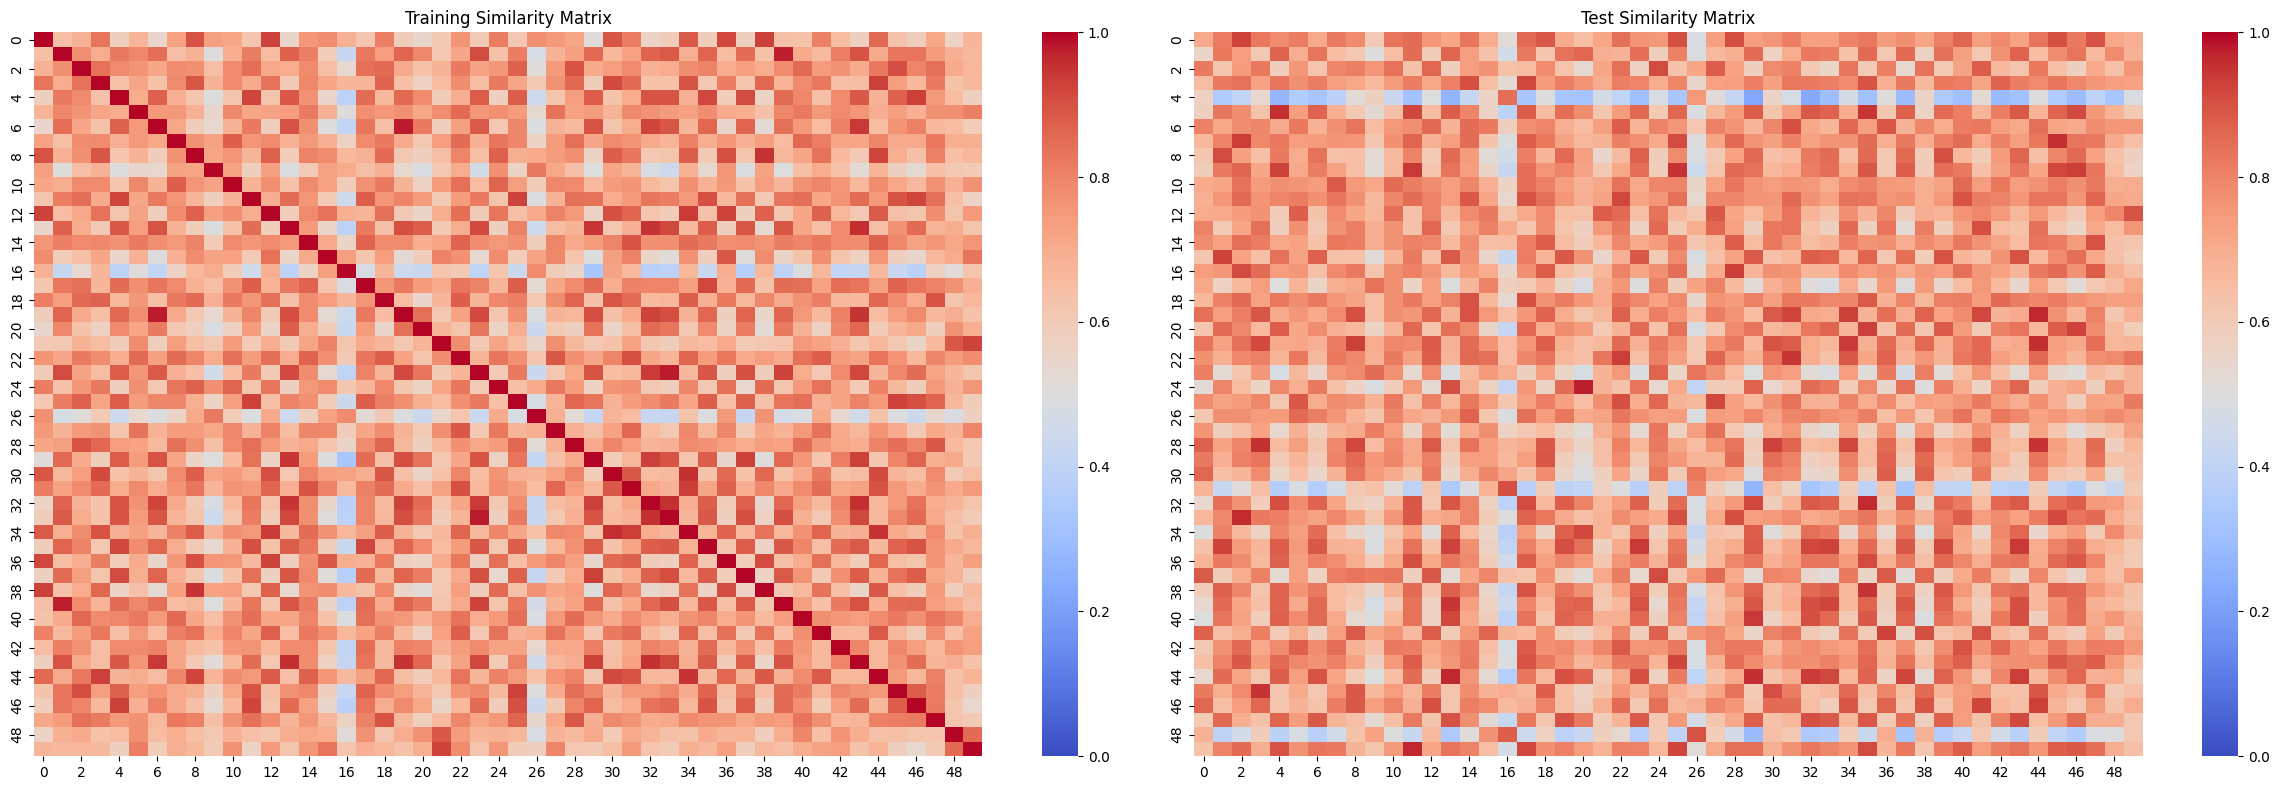

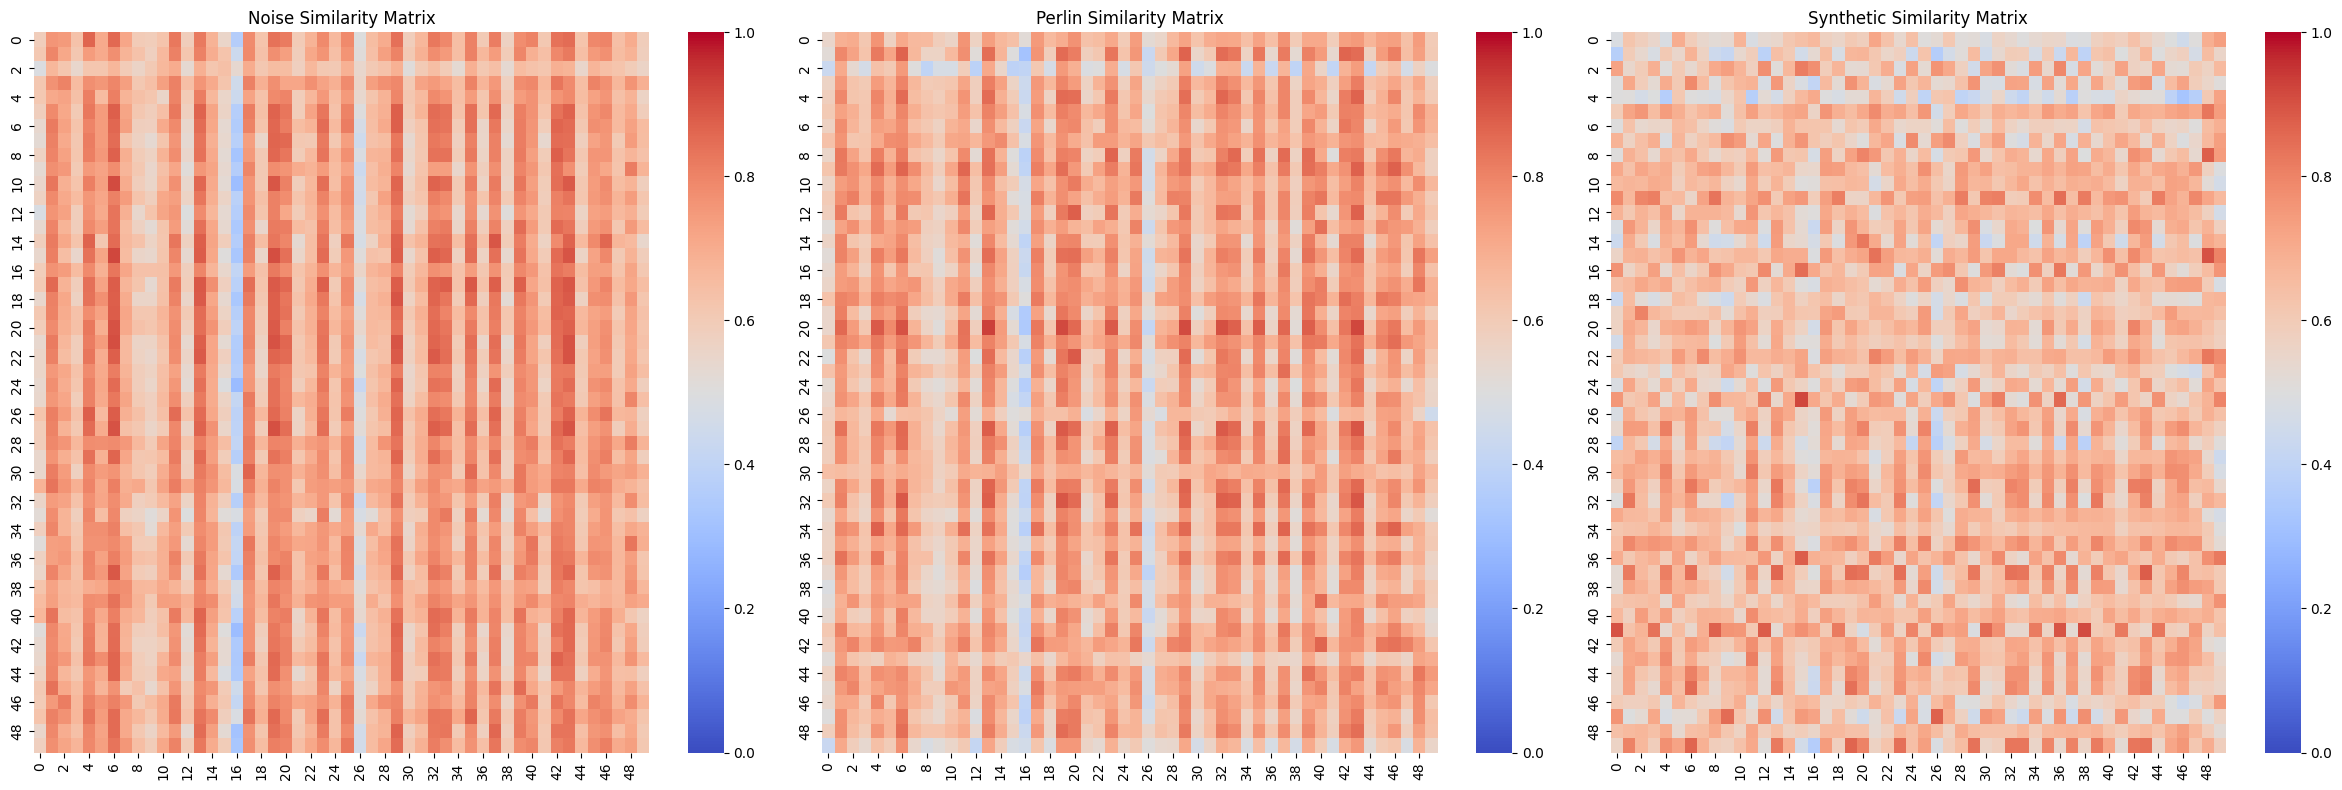

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

TO_PRINT = True
if TO_PRINT:
    fig, axes = plt.subplots(1, 2, figsize=(24, 8))  # Create a grid with 1 row and 3 columns

    # Training Similarity Matrix
    sns.heatmap(K_train, annot=False, cmap='coolwarm', vmin=0, vmax=1, ax=axes[0])
    axes[0].set_title('Training Similarity Matrix')

    # Test Similarity Matrix
    sns.heatmap(K_test, annot=False, cmap='coolwarm', vmin=0, vmax=1, ax=axes[1])
    axes[1].set_title('Test Similarity Matrix')

    plt.tight_layout()  # Adjusts spacing to prevent overlap
    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # Create a grid with 1 row and 3 columns

    # Noise Similarity Matrix
    sns.heatmap(K_noise, annot=False, cmap='coolwarm', vmin=0, vmax=1, ax=axes[0])
    axes[0].set_title('Noise Similarity Matrix')

    # Perlin Similarity Matrix
    sns.heatmap(K_perlin, annot=False, cmap='coolwarm', vmin=0, vmax=1, ax=axes[1])

    axes[1].set_title('Perlin Similarity Matrix')

    # Synthetic Similarity Matrix
    sns.heatmap(K_synthetic, annot=False, cmap='coolwarm', vmin=0, vmax=1, ax=axes[2])
    axes[2].set_title('Synthetic Similarity Matrix')

    plt.tight_layout()  # Adjusts spacing to prevent overlap
    plt.show()
